# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, VotingClassifier

# Obtain Data

In [2]:
df = pd.read_csv('../Data/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Scrub Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Drop columns not useful for modeling

In [4]:
df.drop(columns=['PassengerId', 'Ticket', 'Cabin', 'Parch', 'SibSp', 'Fare'], inplace=True)
df.head()

,Survived,Pclass,Name,Sex,Age,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,S
4,0,3,"Allen, Mr. William Henry",male,35.0,S


Create dummy columns for Pclass and categorical variables

In [5]:
df = pd.get_dummies(df, columns=['Pclass', 'Sex'], drop_first=False)
df.drop(columns=['Pclass_2', 'Sex_female'], inplace=True)
df.head()

,Survived,Name,Age,Embarked,Pclass_1,Pclass_3,Sex_male
0,0,"Braund, Mr. Owen Harris",22.0,S,0,1,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,C,1,0,0
2,1,"Heikkinen, Miss. Laina",26.0,S,0,1,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,S,1,0,0
4,0,"Allen, Mr. William Henry",35.0,S,0,1,1


Create dummy columns for Embarked variable, while mantaining Embarked np.nan values in the dummy columns

In [6]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=False, dummy_na=True)
df.drop(columns=['Embarked_Q'], inplace=True)

def embarked_na(row):
    if row['Embarked_nan'] == 1:
        row['Embarked_S'] = np.nan
        row['Embarked_C'] = np.nan
        return row
    else:
        return row

df = df.apply(embarked_na, axis=1)
df.drop(columns='Embarked_nan', inplace=True)
df.head()

,Survived,Name,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S
0,0,"Braund, Mr. Owen Harris",22.0,0,1,1,0.0,1.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,0,1.0,0.0
2,1,"Heikkinen, Miss. Laina",26.0,0,1,0,0.0,1.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,0,0.0,1.0
4,0,"Allen, Mr. William Henry",35.0,0,1,1,0.0,1.0


Create Title feature from Name

In [7]:
df['Title'] = df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df.drop(columns=['Name'], inplace=True)
df.head()

,Survived,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title
0,0,22.0,0,1,1,0.0,1.0,Mr
1,1,38.0,1,0,0,1.0,0.0,Mrs
2,1,26.0,0,1,0,0.0,1.0,Miss
3,1,35.0,1,0,0,0.0,1.0,Mrs
4,0,35.0,0,1,1,0.0,1.0,Mr


Merge all special titles into a single class

In [8]:
def special_title(row):
    if row['Title'] in ['Mr', 'Miss', 'Mrs', 'Master']:
        return row['Title']
    elif row['Title'] in ['Mlle', 'Ms']:
        return 'Miss'
    elif row['Sex_male'] == 0:
        return 'Mrs'
    else: 
        return 'Special'
df['Title'] = df.apply(special_title, axis=1)
df.head()

,Survived,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title
0,0,22.0,0,1,1,0.0,1.0,Mr
1,1,38.0,1,0,0,1.0,0.0,Mrs
2,1,26.0,0,1,0,0.0,1.0,Miss
3,1,35.0,1,0,0,0.0,1.0,Mrs
4,0,35.0,0,1,1,0.0,1.0,Mr


Create dummy variables for Title feature

In [9]:
df = pd.get_dummies(df, columns=['Title'], drop_first=False)
df.drop(columns=['Title_Special'], inplace=True)
df.head()

,Survived,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,22.0,0,1,1,0.0,1.0,0,0,1,0
1,1,38.0,1,0,0,1.0,0.0,0,0,0,1
2,1,26.0,0,1,0,0.0,1.0,0,1,0,0
3,1,35.0,1,0,0,0.0,1.0,0,0,0,1
4,0,35.0,0,1,1,0.0,1.0,0,0,1,0


Impute missing age values with knn imputer

In [10]:
impute_x = df.drop(columns=['Survived'])
impute_y = df['Survived']

impute_xtrain, impute_xtest, impute_ytrain, impute_ytest = train_test_split(impute_x, impute_y, 
                                                                            test_size=0.25, random_state=121)

impute_ss = StandardScaler()
impute_ss.fit(impute_xtrain)
impute_xtrain = pd.DataFrame(impute_ss.transform(impute_xtrain), columns=impute_xtrain.columns, 
                             index=impute_xtrain.index)
impute_x = pd.DataFrame(impute_ss.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

imputer = KNNImputer()
imputer.fit(impute_xtrain)
impute_x = pd.DataFrame(imputer.transform(impute_x), columns=impute_x.columns, index=impute_x.index)

impute_x = pd.DataFrame(impute_ss.inverse_transform(impute_x), columns=impute_x.columns, index=impute_x.index)
df = pd.concat([impute_x, impute_y], axis=1)
df = df.round(4)
df.head()

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Survived
0,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0
1,38.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
2,26.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
3,35.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4,35.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0


Drop all Title features except Special 

In [11]:
df['Title_Special'] = df[['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs']].apply(lambda x: 1-sum(x), axis=1)
df.drop(columns=['Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs'], inplace=True)
df.head()

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Survived,Title_Special
0,22.0,0.0,1.0,1.0,0.0,1.0,0,0.0
1,38.0,1.0,0.0,0.0,1.0,0.0,1,0.0
2,26.0,0.0,1.0,0.0,0.0,1.0,1,0.0
3,35.0,1.0,0.0,0.0,0.0,1.0,1,0.0
4,35.0,0.0,1.0,1.0,0.0,1.0,0,0.0


Confirm data now scrubbed with df.info()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age            891 non-null    float64
 1   Pclass_1       891 non-null    float64
 2   Pclass_3       891 non-null    float64
 3   Sex_male       891 non-null    float64
 4   Embarked_C     891 non-null    float64
 5   Embarked_S     891 non-null    float64
 6   Survived       891 non-null    int64  
 7   Title_Special  891 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 55.8 KB


# Explore Data

Find train set outliers with isolation forest

In [13]:
isf_x = df.drop(columns='Survived')
isf_y = df['Survived']
isf_xtrain, isf_xtest, isf_ytrain, isf_ytest = train_test_split(isf_x, isf_y, test_size=0.25, random_state=121)

isf_ss = StandardScaler()
isf_ss.fit(isf_xtrain)
isf_xtrain = pd.DataFrame(isf_ss.transform(isf_xtrain), columns=isf_xtrain.columns, index=isf_xtrain.index)

isf = IsolationForest(contamination=.02)
isf_xtrain['Outlier'] = isf.fit_predict(isf_xtrain)
isf_xtrain[isf_xtrain['Outlier']==-1].round(1)

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Special,Outlier
626,1.9,-0.5,-1.1,0.7,-0.5,-1.6,6.6,-1
829,2.3,1.8,-1.1,-1.4,0.5,-0.3,-0.2,-1
245,1.0,1.8,-1.1,0.7,-0.5,-1.6,6.6,-1
694,2.1,1.8,-1.1,0.7,-0.5,0.6,6.6,-1
632,0.1,1.8,-1.1,0.7,2.1,-1.6,6.6,-1
536,1.0,1.8,-1.1,0.7,-0.5,0.6,6.6,-1
249,1.7,-0.5,-1.1,0.7,-0.5,0.6,6.6,-1
647,1.8,1.8,-1.1,0.7,2.1,-1.6,6.6,-1
599,1.3,1.8,-1.1,0.7,2.1,-1.6,6.6,-1
745,2.8,1.8,-1.1,0.7,-0.5,0.6,6.6,-1


Find test set outliers with Isolation Forest

In [14]:
isf_xtest = pd.DataFrame(isf_ss.transform(isf_xtest), columns=isf_xtest.columns, index=isf_xtest.index)
isf_xtest['Outlier'] = isf.predict(isf_xtest)
isf_xtest[isf_xtest['Outlier']==-1].round(1)

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Special,Outlier
43,-2.0,-0.5,-1.1,-1.4,2.1,-1.6,-0.2,-1
30,0.7,1.8,-1.1,0.7,2.1,-1.6,6.6,-1
822,0.5,1.8,-1.1,0.7,-0.5,0.6,6.6,-1
317,1.7,-0.5,-1.1,0.7,-0.5,0.6,6.6,-1


Replace all Age values > 4 standard deviations from the mean with the 4 standard deviation value

In [15]:
replace_x = df.drop(columns='Survived')
replace_y = df['Survived']

replace_xtrain, replace_xtest, replace_ytrain, replace_ytest = train_test_split(replace_x, replace_y, 
                                                                            test_size=0.25, random_state=121)

replace_ss = StandardScaler()
replace_ss.fit(replace_xtrain)
replace_xtrain = pd.DataFrame(replace_ss.transform(replace_xtrain), columns=replace_xtrain.columns, 
                             index=replace_xtrain.index)
replace_x = pd.DataFrame(replace_ss.transform(replace_x), columns=replace_x.columns, 
                             index=replace_x.index)

def replace_val(row):
    if row > 4:
        return 4
    if row < -4:
        return -4
    else:
        return row

replace_x['Age'] = replace_x['Age'].apply(replace_val)
replace_x = pd.DataFrame(replace_ss.inverse_transform(replace_x), columns=replace_x.columns, index=replace_x.index)
df = pd.concat([replace_x, replace_y], axis=1)
df = df.round(4)
df.head()

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Special,Survived
0,22.0,0.0,1.0,1.0,0.0,1.0,0.0,0
1,38.0,1.0,0.0,0.0,1.0,0.0,0.0,1
2,26.0,0.0,1.0,0.0,0.0,1.0,0.0,1
3,35.0,1.0,0.0,0.0,0.0,1.0,0.0,1
4,35.0,0.0,1.0,1.0,0.0,1.0,0.0,0


Calculate descriptive statistics for each feature

In [16]:
df.describe().iloc[:, 0:10]

,Age,Pclass_1,Pclass_3,Sex_male,Embarked_C,Embarked_S,Title_Special,Survived
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,30.084330,0.242424,0.551066,0.647587,0.189450,0.724130,0.022447,0.383838
std,13.952564,0.428790,0.497665,0.477990,0.391397,0.446599,0.148214,0.486592
min,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,37.100000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Plot class distribution for Survived dependent variable

[Text(0, 0, '0 (Non-Survivor)'), Text(1, 0, '1 (Survivor)')]

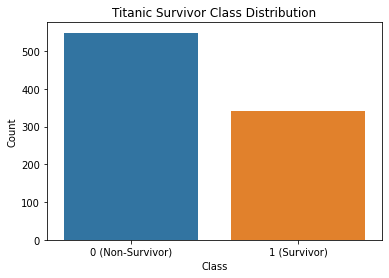

In [17]:
fig, ax = plt.subplots()
sns.countplot(x='Survived', data=df, ax=ax)
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_title('Titanic Survivor Class Distribution')
ax.set_xticklabels(['0 (Non-Survivor)', '1 (Survivor)'])

Plot distribution for each feature in Titanic dataset

C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\blant\AppData\Roaming\Python\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

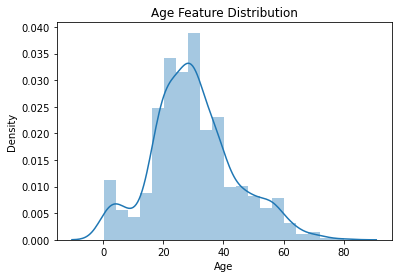

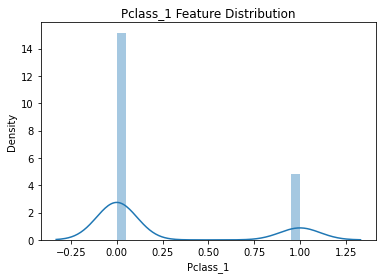

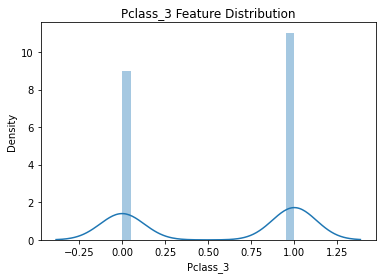

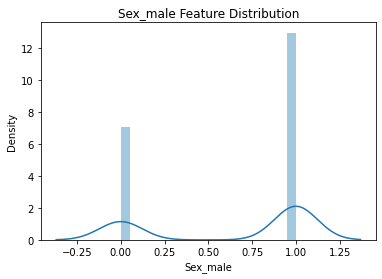

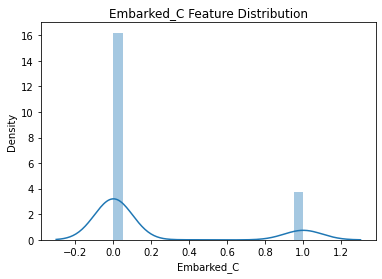

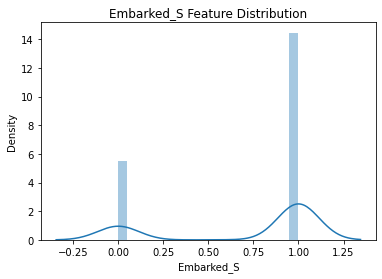

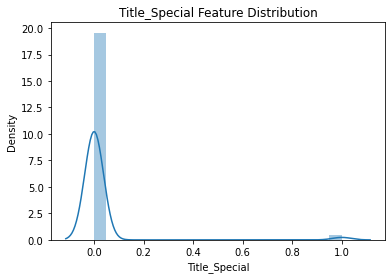

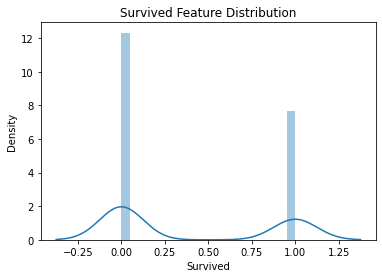

In [18]:
for feat in df.columns:
    fig, ax = plt.subplots()
    sns.distplot(df[feat], kde=True, bins=20)
    ax.set_title(f'{feat} Feature Distribution')

Calculate VIF to confirm that there are no correlated features

In [19]:
vif_x = df.drop(columns=['Survived'])
vif_y = df['Survived']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, test_size=0.25, random_state=121)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,24.8
1,Embarked_C,2.9
2,Embarked_S,2.8
3,Pclass_1,1.9
4,Pclass_3,1.8
5,Age,1.3
6,Sex_male,1.1
7,Title_Special,1.1


# Model Data

Create x and y variables

In [20]:
x = df.drop(columns=['Survived', 'Title_Special'])
y = df['Survived']

Perform train test split

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=121)

Standard scale data

In [22]:
ss = StandardScaler()
ss.fit(x_train)
x_train = pd.DataFrame(ss.transform(x_train), columns=x_train.columns, index=x_train.index)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns, index=x_test.index)

Build and evaluate dummy classifier

In [23]:
dc = DummyClassifier(strategy='stratified', random_state=73)
dc.fit(x_train, y_train)
y_train_pred_dc = dc.predict(x_train)
y_test_pred_dc = dc.predict(x_test)
print('Dummy Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_dc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_dc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_dc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_dc))

Dummy Classifier: 
Train f1 Score:  0.33954451345755693
Train Accuracy Score: 0.5224550898203593
Test f1 Score:  0.28205128205128205
Test Accuracy Score: 0.4977578475336323


Gridsearch Logistic Regression Model

In [29]:
lr_gs_dict = {'C': [x/1000 for x in range(1000, 1201)]}
lr_gs_model = LogisticRegression(random_state=204)
lr_gs = GridSearchCV(lr_gs_model, lr_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
lr_gs.fit(x_train, y_train)

print(lr_gs.best_estimator_)
print(lr_gs.best_score_)

Fitting 5 folds for each of 201 candidates, totalling 1005 fits
LogisticRegression(C=1.106, random_state=204)
0.8023678599483783


Build and evaluate top performing gridsearch logistic regression model

In [24]:
lr = LogisticRegression(C=1.106, random_state=204)
lr.fit(x_train, y_train)
y_train_pred_lr = lr.predict(x_train)
y_test_pred_lr = lr.predict(x_test)
print('Logistic Regression: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_lr))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_lr))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_lr))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_lr))

Logistic Regression: 
Train f1 Score:  0.7357723577235773
Train Accuracy Score: 0.8053892215568862
Test f1 Score:  0.7191011235955056
Test Accuracy Score: 0.7757847533632287


Gridsearch SVC model

In [30]:
svc_gs_dict = {'C': [x/1000 for x in range(630, 731)],
               'gamma': [x/1000 for x in range(230, 331)]}
svc_gs_model = SVC(random_state=491)
svc_gs = GridSearchCV(svc_gs_model, svc_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
svc_gs.fit(x_train, y_train)

print(svc_gs.best_estimator_)
print(svc_gs.best_score_)

Fitting 5 folds for each of 10201 candidates, totalling 51005 fits
SVC(C=0.651, gamma=0.29, random_state=491)
0.8233643811020087


Fit and evaluate top performing SVC model

In [31]:
svc = SVC(C=.651, gamma=.29, random_state=491, probability=True)
svc.fit(x_train, y_train)
y_train_pred_svc = svc.predict(x_train)
y_test_pred_svc = svc.predict(x_test)
print('SVC: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_svc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_svc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_svc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_svc))

SVC: 
Train f1 Score:  0.7331786542923434
Train Accuracy Score: 0.8278443113772455
Test f1 Score:  0.7450980392156863
Test Accuracy Score: 0.8251121076233184


Gridsearch adaboost model

In [35]:
ab_gs_dict = {'learning_rate': [x/1000 for x in range(1000, 2001)],
             'n_estimators': [x*10 for x in range(5, 11)]}
ab_gs_model = AdaBoostClassifier(random_state=19)
ab_gs = GridSearchCV(ab_gs_model, ab_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
ab_gs.fit(x_train, y_train)

print(ab_gs.best_estimator_)
print(ab_gs.best_score_)

Fitting 5 folds for each of 6006 candidates, totalling 30030 fits
AdaBoostClassifier(learning_rate=1.776, random_state=19)
0.8233082706766917


Fit and evaluate top performing adaboost model

In [36]:
ab = AdaBoostClassifier(learning_rate=1.776, n_estimators=50, random_state=19)
ab.fit(x_train, y_train)
y_train_pred_ab = ab.predict(x_train)
y_test_pred_ab = ab.predict(x_test)
print('Adaboost: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_ab))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_ab))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_ab))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_ab))

Adaboost: 
Train f1 Score:  0.7670682730923695
Train Accuracy Score: 0.8263473053892215
Test f1 Score:  0.7078651685393259
Test Accuracy Score: 0.7668161434977578


Gridsearch random forest model

In [45]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [1/6, 2/6, 3/6, 4/6, 5/6, 6/6],
              'max_leaf_nodes': [x for x in range(40, 60)],
              'max_samples': [x/100 for x in range(80, 101)]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 5040 candidates, totalling 25200 fits
RandomForestClassifier(max_features=0.6666666666666666, max_leaf_nodes=56,
                       max_samples=0.91, n_jobs=-1, random_state=712)
0.8322859387274155


In [57]:
rf_gs_dict = {'criterion': ['gini', 'entropy'],
              'max_features': [1/6, 2/6, 3/6, 4/6, 5/6, 6/6],
              'max_samples': [x/1000 for x in range(100, 201)],
              'min_impurity_decrease': [x/100 for x in range(0, 21, 2)]}
rf_gs_model = RandomForestClassifier(random_state=712, n_jobs=-1)
rf_gs = GridSearchCV(rf_gs_model, rf_gs_dict, scoring='accuracy', n_jobs=-1, cv=5, verbose=1)
rf_gs.fit(x_train, y_train)

print(rf_gs.best_estimator_)
print(rf_gs.best_score_)

Fitting 5 folds for each of 13332 candidates, totalling 66660 fits
RandomForestClassifier(max_features=0.8333333333333334, max_samples=0.172,
                       n_jobs=-1, random_state=712)
0.8307934014139826


Fit and evaluate top performing random forest model

In [46]:
rf = RandomForestClassifier(criterion='gini', max_features=4/6, max_leaf_nodes=56, max_samples=0.91, n_jobs=-1,
                       random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.8701030927835052
Train Accuracy Score: 0.905688622754491
Test f1 Score:  0.7093023255813955
Test Accuracy Score: 0.7757847533632287


In [58]:
rf = RandomForestClassifier(criterion='entropy', max_features=5/6, max_samples=0.172,
                       min_impurity_decrease=0, n_jobs=-1, random_state=712)
rf.fit(x_train, y_train)
y_train_pred_rf = rf.predict(x_train)
y_test_pred_rf = rf.predict(x_test)
print('Random Forest: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_rf))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_rf))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_rf))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_rf))

Random Forest: 
Train f1 Score:  0.803347280334728
Train Accuracy Score: 0.8592814371257484
Test f1 Score:  0.7085714285714286
Test Accuracy Score: 0.7713004484304933


Fit and evaluate voting classifier

In [ ]:
vc = VotingClassifier([('svc', svc), ('rf', rf)], voting='soft', weights=[1, 0])
vc.fit(x_train, y_train)
y_train_pred_vc = vc.predict(x_train)
y_test_pred_vc = vc.predict(x_test)
print('Voting Classifier: ')
print('Train f1 Score: ', f1_score(y_train, y_train_pred_vc))
print('Train Accuracy Score:', accuracy_score(y_train, y_train_pred_vc))
print('Test f1 Score: ', f1_score(y_test, y_test_pred_vc))
print('Test Accuracy Score:', accuracy_score(y_test, y_test_pred_vc))